In [87]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.text import Text
import seaborn as sns

import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import plot_functions as PF
import TrialAnalyses as TA
import analyses_table as AT
from importlib import reload  # Python 3.4+ only.

In [88]:
oakPaths = AT.getOakPaths()

In [89]:
sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})


In [90]:

#task = 'T3g'
animals = ['Li','Ne','Cl']
overwrite=False
doPlots = False

cols = ['se','an','task','nTrials','nDiscard','nCo','nInCo','nLD','nRD','nLC','nRC','nST','pCo','pCoST']
allBehDat = pd.DataFrame()
for animal in animals:    
    fn = oakPaths['Root'] / (animal+'_SessionPaths.pkl')
    with fn.open(mode="rb") as f:
        sePaths = pkl.load(f)

    CT_Path =  oakPaths['Clustered'] / animal / (animal+'_ClusteringSummary.json')
    with CT_Path.open() as f:
        CT = json.load(f)

    for se,v in CT['Sessions'].items():
        if v:
            try:
                temp = se.split('_')
                if temp[1][:2]=='T3':
                    TrialConds = pd.read_csv(sePaths[se]['TrialCondMat'] ,index_col=0)
                    X = TrialConds[TrialConds['Good']]
                    
                    behDat = pd.DataFrame(np.zeros((1,len(cols))),columns=cols )
                    behDat['se'] = se
                    behDat['an'] = animal
                    behDat['task'] = temp[1]

                    behDat['nTrials'] = X.shape[0]
                    behDat['nDiscard'] = np.sum(~TrialConds['Good'])
                    behDat['nCo'] = np.sum(X['Co']=='Co')
                    behDat['nInCo'] = np.sum(X['Co']=='InCo')
                    behDat['nLD'] = np.sum(X['Desc']=='L')
                    behDat['nRD'] = np.sum(X['Desc']=='R')
                    behDat['nLC'] = np.sum(X['Cues']=='L')
                    behDat['nRC'] = np.sum(X['Cues']=='R')

                    ST = ~(X['Cues'].values[0:-1]==X['Cues'].values[1:])
                    CoT = (X['Co']=='Co').values

                    behDat['nST'] = np.sum(ST)
                    behDat['pCo'] = np.mean(CoT)
                    behDat['pCoST'] = CoT[np.where(ST)[0]+1].mean()

                    allBehDat = pd.concat((allBehDat,behDat))
            except:
                print("Error processing session: {}".format(se))
                print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)
                pass


allBehDat.to_csv(oakPaths['Analyses'] / 'TaskBehavior.csv')

Error processing session: Ne_T3gj_062718
Error <class 'KeyError'> 'Ne_T3gj_062718' 23
Error processing session: Ne_T3gj_062818
Error <class 'KeyError'> 'Ne_T3gj_062818' 23
Error processing session: Ne_T3g_053018
Error <class 'KeyError'> 'Co' 33
Error processing session: Cl_T3g_112118
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Cl/Cl_T3g_112118_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Cl/Cl_T3g_112118_Analyses/TrialCondMat.csv' 23
Error processing session: Cl_T3i_021219
Error <class 'FileNotFoundError'> [Errno 2] File b'/mnt/o/giocomo/alexg/Analyses/Cl/Cl_T3i_021219_Analyses/TrialCondMat.csv' does not exist: b'/mnt/o/giocomo/alexg/Analyses/Cl/Cl_T3i_021219_Analyses/TrialCondMat.csv' 23


In [90]:
allBehDat.to_csv(oakPaths['Analyses'] / 'TaskBehavior.csv')

In [5]:
allBehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
allBehDat

,se,an,task,nTrials,nDiscard,nCo,nInCo,nLD,nRD,nLC,nRC,nST,pCo,pCoST
0,Li_T3g_052818,Li,T3g,39,21,27,12,16,23,20,19,23,0.692308,0.782609
0,Li_T3g_052918,Li,T3g,154,24,133,21,74,80,81,73,51,0.863636,0.862745
0,Li_T3g_053018,Li,T3g,121,24,98,23,36,85,55,66,49,0.809917,0.816327
0,Li_T3g_053118,Li,T3g,140,20,111,29,54,86,71,69,69,0.792857,0.840580
0,Li_T3g_060118,Li,T3g,157,18,132,25,69,88,78,79,63,0.840764,0.857143
0,Li_T3g_060418,Li,T3g,129,15,108,21,64,65,73,56,55,0.837209,0.872727
0,Li_T3g_061318,Li,T3g,123,31,92,31,60,63,67,56,65,0.747967,0.707692
0,Li_T3g_061518,Li,T3g,112,17,73,39,68,44,65,47,61,0.651786,0.540984
0,Li_T3g_061818,Li,T3g,135,20,110,25,61,74,62,73,68,0.814815,0.867647
0,Li_T3g_062018,Li,T3g,168,22,132,36,91,77,95,73,86,0.785714,0.837209


In [96]:
allBehDat.head()

,se,an,task,nTrials,nDiscard,nCo,nInCo,nLD,nRD,nLC,nRC,nST,pCo,pCoST
0,Li_T3g_052818,Li,T3g,38,22,27,11,16,22,19,19,21,0.710526,0.809524
0,Li_T3g_052918,Li,T3g,154,24,133,21,74,80,81,73,51,0.863636,0.862745
0,Li_T3g_053018,Li,T3g,121,24,98,23,36,85,55,66,49,0.809917,0.816327
0,Li_T3g_053118,Li,T3g,140,20,111,29,54,86,71,69,69,0.792857,0.840580
0,Li_T3g_060118,Li,T3g,159,16,134,25,70,89,79,80,63,0.842767,0.857143


In [20]:
m = allBehDat.groupby(['an','task']).mean()[[ 'pCo','pCoST' ] ]
s = allBehDat.groupby(['an','task']).std()[[ 'pCo','pCoST' ] ]
m

,,pCo,pCoST
an,task,,
Cl,T3g,0.816799,0.889705
Li,T3g,0.765376,0.787195
Ne,T3g,0.836362,0.897012


In [36]:
m['pCo'],s['pCo']

(an  task
 Cl  T3g     0.816799
 Li  T3g     0.765376
 Ne  T3g     0.836362
 Name: pCo, dtype: float64, an  task
 Cl  T3g     0.067839
 Li  T3g     0.078800
 Ne  T3g     0.057394
 Name: pCo, dtype: float64)

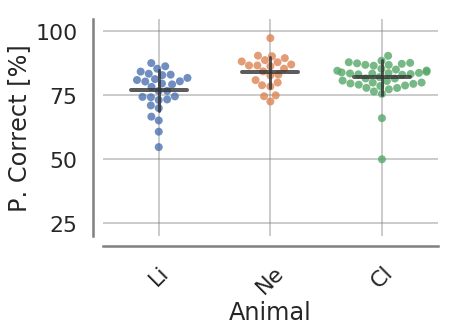

In [98]:
sns.set_context("poster")
sns.axes_style('whitegrid')

plotSP = Path('/mnt/c/Users/alexg8/Documents/SfN2019/Plots/')

m = np.array([0.77,0.84,0.82])
s = np.array([0.08,0.06,0.07])

subset = allBehDat['task']=='T3g'
f,ax= plt.subplots()
ax.set_ylim([0.2,1.05])
#sns.barplot(x='an',y='pCo',data=allBehDat,alpha=0.5,ax=ax)
ax=sns.swarmplot(x='an',y='pCo',data=allBehDat[subset],alpha=0.8,size=8,ax=ax)

for ii in np.arange(3):
    ax.plot( [ii,ii], [m[ii]-s[ii],m[ii]+s[ii]], linewidth=3,color='0.2',zorder=3,solid_capstyle='round',alpha=0.8)
    ax.plot( [ii-0.25,ii+0.25], [m[ii],m[ii]], linewidth=4,color='0.2',zorder=3,solid_capstyle='round',alpha=0.8)

ax.grid()
sns.despine(offset=10, trim=False,ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.grid(axis='both',color='grey',alpha=0.4)
#ax.set_ylim([0,1])


ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels([25,50,75,100])
ax.set_xlabel('Animal')
ax.set_ylabel('P. Correct [%]')

f.savefig(plotSP / 'anBehavPCo.svg', bbox_inches='tight', pad_inches=0.2)


In [103]:
subset = allBehDat['task']=='T3i'
m = allBehDat.groupby(['an','task']).mean()[[ 'pCo','pCoST' ] ]
m

pCo     pCoST
an task                    
Cl T3g   0.816005  0.890691
   T3i   0.624948  0.590681
Li T3g   0.766809  0.789918
   T3i   0.636091  0.527918
Ne T3g   0.843497  0.897018
   T3i   0.607298  0.612015
   T3j   0.853659  0.920000

In [46]:
m = allBehDat.groupby(['an','task']).mean()[[ 'pCoST' ] ]
s = allBehDat.groupby(['an','task']).std()[[ 'pCoST' ] ]
m['pCoST'],s['pCoST']

(an  task
 Cl  T3g     0.889705
 Li  T3g     0.787195
 Ne  T3g     0.897012
 Name: pCoST, dtype: float64, an  task
 Cl  T3g     0.060607
 Li  T3g     0.077626
 Ne  T3g     0.060528
 Name: pCoST, dtype: float64)

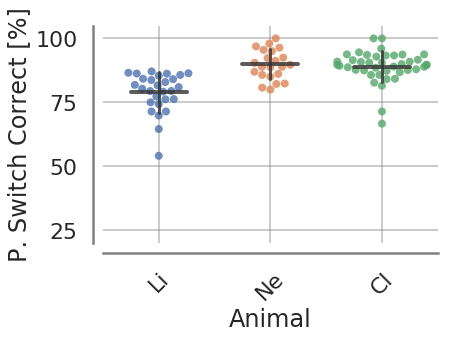

In [99]:
m = np.array([0.79,0.90,0.89])
s = np.array([0.08,0.06,0.06])

f,ax= plt.subplots()
ax.set_ylim([0.2,1.05])
#sns.barplot(x='an',y='pCo',data=allBehDat,alpha=0.5,ax=ax)
ax=sns.swarmplot(x='an',y='pCoST',data=allBehDat[subset],alpha=0.8,size=8,ax=ax)

for ii in np.arange(3):
    ax.plot( [ii,ii], [m[ii]-s[ii],m[ii]+s[ii]], linewidth=3,color='0.2',zorder=3,solid_capstyle='round',alpha=0.8)
    ax.plot( [ii-0.25,ii+0.25], [m[ii],m[ii]], linewidth=4,color='0.2',zorder=3,solid_capstyle='round',alpha=0.8)

ax.grid()
sns.despine(offset=10, trim=False,ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.grid(axis='both',color='grey',alpha=0.4)
#ax.set_ylim([0,1])
ax.set_xlabel('Animal')
ax.set_ylabel('P. Correct')


ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels([25,50,75,100])
ax.set_xlabel('Animal')
ax.set_ylabel('P. Switch Correct [%]')

f.savefig(plotSP / 'anBehavPCoST.svg', bbox_inches='tight', pad_inches=0.2)

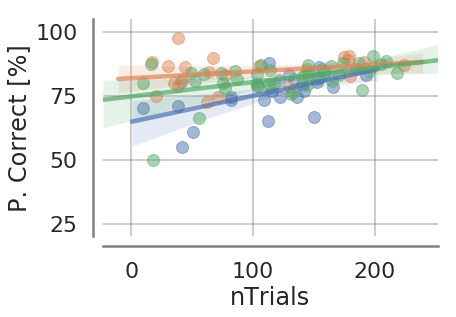

In [100]:
sns.set_context('poster')
f,ax= plt.subplots()
ax.set_ylim([0.2,1.05])
subset = (allBehDat['an']=='Li') & (allBehDat['task']=='T3g')
ax = sns.regplot(x='nTrials',y='pCo',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7},ax=ax)
subset = (allBehDat['an']=='Ne') & (allBehDat['task']=='T3g')
ax = sns.regplot(x='nTrials',y='pCo',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7},ax=ax)
subset = (allBehDat['an']=='Cl') & (allBehDat['task']=='T3g')
ax = sns.regplot(x='nTrials',y='pCo',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7} ,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)


sns.despine(offset=10, trim=False,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)
ax.set_xlabel('nTrials')

ax.set_ylabel('P. Correct [%]')

ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels([25,50,75,100])
f.savefig(plotSP / 'anBehavPCoVnTrials.svg', bbox_inches='tight', pad_inches=0.2)

[Text(0, 0, '25'), Text(0, 0, '50'), Text(0, 0, '75'), Text(0, 0, '100')]

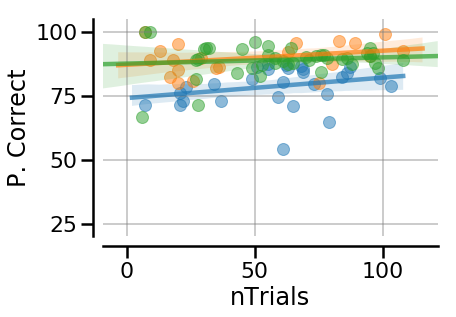

In [80]:
f,ax= plt.subplots(1)
ax.set_ylim([0.2,1.05])
subset = allBehDat['an']=='Li'
ax = sns.regplot(x='nST',y='pCoST',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7},ax=ax)
subset = allBehDat['an']=='Ne'
ax = sns.regplot(x='nST',y='pCoST',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7},ax=ax)
subset = allBehDat['an']=='Cl'
ax = sns.regplot(x='nST',y='pCoST',data=allBehDat[subset],scatter_kws = {'alpha':0.5},line_kws = {'alpha':0.7} ,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)


sns.despine(offset=10, trim=False,ax=ax)
ax.grid(axis='both',color='grey',alpha=0.4)
ax.set_xlabel('nTrials')

ax.set_ylabel('P. Correct')

ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels([25,50,75,100])

In [53]:
behDat

,se,nTrials,nDiscard,nCo,nInCo,nLD,nRD,nLC,nRC,nST,pCo,pCoST
0,Li_T3g_062718,194,17,161,33,105,89,110,84,99,0.829897,0.818182
